# Modelagem de séries temporais usando redes neurais recorrentes


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter # filtro para suavizar a série

In [2]:
# Leitura dos dados de COVID-19 do Brasil

pkgdir = 'Data'

df = pd.read_csv(f'{pkgdir}/owid-covid-data.csv', index_col='date', parse_dates=True)
df = df[df['location']=='Brazil']
population = df['population'][0]

# Seleciona apenas o número de casos e mortes diários
df = df[['new_cases','new_deaths']]

# Preenche os dados faltantes com interploção spline
df.interpolate('spline',order=2,inplace=True)

# filtragem da série usando o filtro Savitzky-Golay
df['new_cases'] = savgol_filter(df['new_cases'], 7, 2)
df['new_deaths'] = savgol_filter(df['new_deaths'], 7, 2)

#df2 = pd.DataFrame()
#window = 35
#df2['new_cases_f'] = pd.Series(df['new_cases']).rolling(window=window).mean().iloc[window-1:].values
#df2['new_deaths_f'] = pd.Series(df['new_deaths']).rolling(window=window).mean().iloc[window-1:].values
#df2.index = df.index[np.int((window-1)/2):-np.int((window-1)/2)]
#df = df2

df.columns = ['new_cases','new_deaths']
df = df[df.index>'2020-04-01']
df = df[df.index<'2021-06-01']

idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(idx)
df.fillna(0,inplace=True)

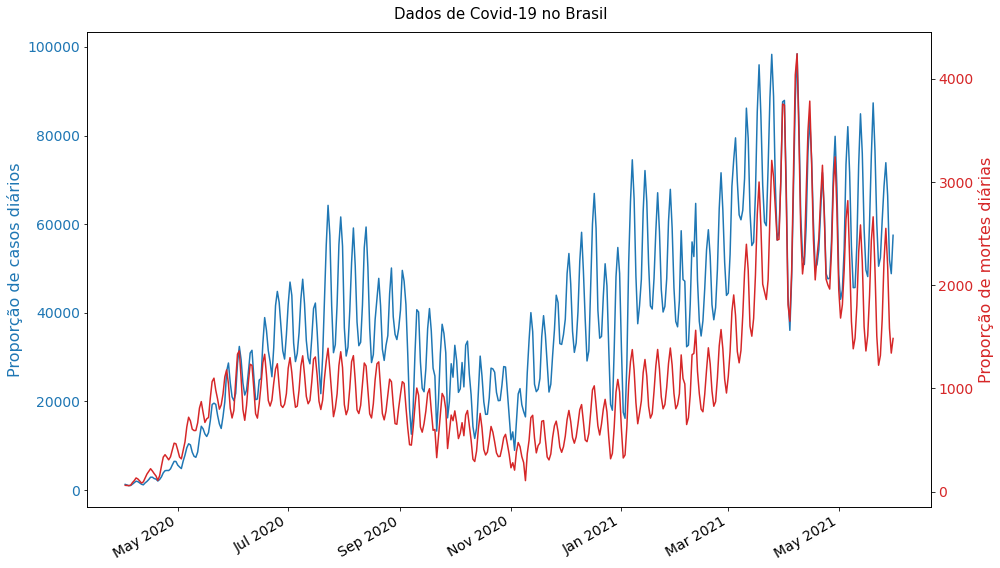

In [3]:
fig, ax1 = plt.subplots(figsize=(14,8))

color = 'tab:blue'
ax1.set_ylabel('Proporção de casos diários', color=color, fontsize=16)
ax1.plot(df['new_cases'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Proporção de mortes diárias', color=color, fontsize=16)  # we already handled the x-label with ax1
ax2.plot(df['new_deaths'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='both', which='major', labelsize=14)
date_fmt = mdates.DateFormatter('%b %Y')
ax1.xaxis.set_major_formatter(date_fmt)
ax2.xaxis.set_major_formatter(date_fmt)
fig.suptitle("Dados de Covid-19 no Brasil",
             fontsize=15)
fig.autofmt_xdate()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Importante: Os dados precisam estar normalizados

In [4]:
# Normalização pela população vezes 10^3 e 10^4 para o número de casos e de mortes, respectivamente,
# para os valores não ficarem tão próximos a zero
df = [1000,10000]*df/population

## Divida a base em treino e teste

In [5]:
train = df.iloc[:-28]
test = df.iloc[-28:]

Y_train = train.to_numpy()
Y_test = test.to_numpy()

### Gerador de séries temporais


In [6]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [7]:
# Vamos redefinir lotes de tamanho 28 para o procedimento iterativo
# Veja mais informações sobre o tamanho do lote http://deeplearningbook.com.br/o-efeito-do-batch-size-no-treinamento-de-redes-neurais-artificiais/

n_input_cases = 28
n_input_deaths = 14
n_features = 1
generator_cases = TimeseriesGenerator(Y_train[:,[0]], Y_train[:,[1]], length=n_input_cases, batch_size=1)
generator_only_deaths = TimeseriesGenerator(Y_train[:,[1]], Y_train[:,[1]], length=n_input_deaths, batch_size=1)

### Definição do modelo usando Keras

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [9]:
# Modelo usando o número de casos como preditora
model_cases = Sequential()
model_cases.add(LSTM(56, activation='relu', unroll = True, input_shape=(n_input_cases, n_features)))
model_cases.add(Dense(1))
model_cases.compile(optimizer='adam', loss='mse')

In [10]:
model_cases.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 56)                12992     
_________________________________________________________________
dense (Dense)                (None, 1)                 57        
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Modelo usando o número de mortes
model_deaths = Sequential()
model_deaths.add(LSTM(56, activation='relu', unroll = True, input_shape=(n_input_deaths, n_features)))
model_deaths.add(Dense(1))
model_deaths.compile(optimizer='adam', loss='mse')

In [12]:
model_deaths.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 56)                12992     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 57        
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Ajuste do modelo com o número de casos diários

model_cases.fit(generator_cases,epochs=200)

Epoch 1/200
369/369 [==============================] - 4s 3ms/step - loss: 6.4864e-04
Epoch 2/200
369/369 [==============================] - 1s 3ms/step - loss: 5.3495e-04
Epoch 3/200
369/369 [==============================] - 1s 3ms/step - loss: 5.1991e-04
Epoch 4/200
369/369 [==============================] - 1s 3ms/step - loss: 4.1855e-04
Epoch 5/200
369/369 [==============================] - 1s 3ms/step - loss: 3.7664e-04
Epoch 6/200
369/369 [==============================] - 1s 3ms/step - loss: 3.8140e-04
Epoch 7/200
369/369 [==============================] - 1s 3ms/step - loss: 3.8388e-04
Epoch 8/200
369/369 [==============================] - 1s 3ms/step - loss: 3.6088e-04
Epoch 9/200
369/369 [==============================] - 1s 3ms/step - loss: 4.3690e-04
Epoch 10/200
369/369 [==============================] - 1s 3ms/step - loss: 3.7855e-04
Epoch 11/200
369/369 [==============================] - 1s 3ms/step - loss: 3.5471e-04
Epoch 12/200
369/369 [==============================

369/369 [==============================] - 1s 3ms/step - loss: 1.0918e-04
Epoch 96/200
369/369 [==============================] - 1s 3ms/step - loss: 1.1333e-04A: 0s
Epoch 97/200
369/369 [==============================] - 1s 3ms/step - loss: 1.1644e-04
Epoch 98/200
369/369 [==============================] - 1s 3ms/step - loss: 1.1002e-04
Epoch 99/200
369/369 [==============================] - 1s 3ms/step - loss: 1.0749e-04
Epoch 100/200
369/369 [==============================] - 1s 3ms/step - loss: 1.0499e-04
Epoch 101/200
369/369 [==============================] - 1s 3ms/step - loss: 1.6706e-04
Epoch 102/200
369/369 [==============================] - 1s 3ms/step - loss: 1.0010e-04
Epoch 103/200
369/369 [==============================] - 1s 3ms/step - loss: 1.0755e-04
Epoch 104/200
369/369 [==============================] - 1s 3ms/step - loss: 1.0384e-04
Epoch 105/200
369/369 [==============================] - 1s 3ms/step - loss: 1.1532e-04
Epoch 106/200
369/369 [======================

369/369 [==============================] - 1s 3ms/step - loss: 7.5221e-05
Epoch 188/200
369/369 [==============================] - 1s 3ms/step - loss: 1.1405e-04
Epoch 189/200
369/369 [==============================] - 1s 3ms/step - loss: 6.2257e-05
Epoch 190/200
369/369 [==============================] - 1s 3ms/step - loss: 6.4769e-05
Epoch 191/200
369/369 [==============================] - 1s 3ms/step - loss: 6.0176e-05
Epoch 192/200
369/369 [==============================] - 1s 3ms/step - loss: 5.4309e-05
Epoch 193/200
369/369 [==============================] - 1s 3ms/step - loss: 5.9332e-05
Epoch 194/200
369/369 [==============================] - 1s 3ms/step - loss: 6.2700e-05
Epoch 195/200
369/369 [==============================] - 1s 3ms/step - loss: 5.6684e-05
Epoch 196/200
369/369 [==============================] - 1s 3ms/step - loss: 6.5095e-05
Epoch 197/200
369/369 [==============================] - 1s 3ms/step - loss: 6.5342e-05
Epoch 198/200
369/369 [=======================

In [14]:
# Ajuste do modelo apenas com o número de mortes diárias

model_deaths.fit(generator_only_deaths,epochs=200)

Epoch 1/200
383/383 [==============================] - 2s 2ms/step - loss: 4.0277e-04
Epoch 2/200
383/383 [==============================] - 1s 2ms/step - loss: 2.9466e-04
Epoch 3/200
383/383 [==============================] - 1s 2ms/step - loss: 3.0069e-04
Epoch 4/200
383/383 [==============================] - 1s 2ms/step - loss: 2.7911e-04
Epoch 5/200
383/383 [==============================] - 1s 2ms/step - loss: 2.5904e-04
Epoch 6/200
383/383 [==============================] - 1s 2ms/step - loss: 2.6544e-04
Epoch 7/200
383/383 [==============================] - 1s 2ms/step - loss: 2.7945e-04
Epoch 8/200
383/383 [==============================] - 1s 2ms/step - loss: 2.4624e-04
Epoch 9/200
383/383 [==============================] - 1s 2ms/step - loss: 2.6343e-04
Epoch 10/200
383/383 [==============================] - 1s 2ms/step - loss: 2.3567e-04
Epoch 11/200
383/383 [==============================] - 1s 2ms/step - loss: 2.3623e-04
Epoch 12/200
383/383 [==============================

Epoch 95/200
383/383 [==============================] - 1s 2ms/step - loss: 1.9033e-05
Epoch 96/200
383/383 [==============================] - 1s 2ms/step - loss: 2.2562e-05
Epoch 97/200
383/383 [==============================] - 1s 2ms/step - loss: 2.0887e-05
Epoch 98/200
383/383 [==============================] - 1s 2ms/step - loss: 2.4692e-05
Epoch 99/200
383/383 [==============================] - 1s 2ms/step - loss: 2.2778e-05
Epoch 100/200
383/383 [==============================] - 1s 2ms/step - loss: 2.1936e-05
Epoch 101/200
383/383 [==============================] - 1s 2ms/step - loss: 2.1358e-05
Epoch 102/200
383/383 [==============================] - 1s 2ms/step - loss: 2.3736e-05
Epoch 103/200
383/383 [==============================] - 1s 2ms/step - loss: 2.1054e-05
Epoch 104/200
383/383 [==============================] - 1s 2ms/step - loss: 2.4278e-05
Epoch 105/200
383/383 [==============================] - 1s 2ms/step - loss: 2.4138e-05
Epoch 106/200
383/383 [==============

383/383 [==============================] - 1s 2ms/step - loss: 1.6403e-05
Epoch 188/200
383/383 [==============================] - 1s 2ms/step - loss: 1.6088e-05
Epoch 189/200
383/383 [==============================] - 1s 2ms/step - loss: 1.7849e-05
Epoch 190/200
383/383 [==============================] - 1s 2ms/step - loss: 1.7506e-05
Epoch 191/200
383/383 [==============================] - 1s 2ms/step - loss: 1.6426e-05
Epoch 192/200
383/383 [==============================] - 1s 2ms/step - loss: 1.6512e-05
Epoch 193/200
383/383 [==============================] - 1s 2ms/step - loss: 1.6009e-05
Epoch 194/200
383/383 [==============================] - 1s 2ms/step - loss: 1.7121e-05
Epoch 195/200
383/383 [==============================] - 1s 2ms/step - loss: 1.7322e-05
Epoch 196/200
383/383 [==============================] - 1s 2ms/step - loss: 1.8007e-05
Epoch 197/200
383/383 [==============================] - 1s 2ms/step - loss: 1.5288e-05
Epoch 198/200
383/383 [=======================

**Erro dos modelos no aprendizado**

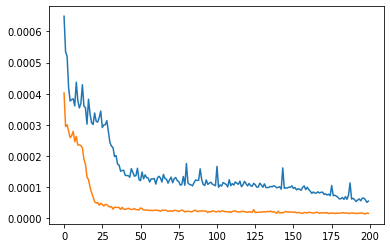

In [15]:
model_cases_loss = model_cases.history.history['loss']
model_deaths_loss = model_deaths.history.history['loss']
plt.plot(range(len(model_cases_loss)),model_cases_loss)
plt.plot(range(len(model_deaths_loss)),model_deaths_loss)

## Avaliação em dados de teste

In [16]:
# Agora vamos calcular as previsões do model_cases para as próximas observações

test_predictions_cases = []

first_eval_batch = Y_train[-n_input_cases:,[0]]
current_batch = first_eval_batch.reshape((1, n_input_cases, n_features))

for i in range(len(test)):
    current_batch = np.append(current_batch[:,1:,:],[[Y_test[i,[0]]]],axis=1)
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model_cases.predict(current_batch)[0]
    
    # predição
    test_predictions_cases.append(current_pred) 
    

In [17]:
# Agora vamos calcular as previsões do model_deaths para as próximas observações

test_predictions_deaths = []

first_eval_batch = Y_train[-n_input_deaths:,[1]]
current_batch = first_eval_batch.reshape((1, n_input_deaths, n_features))

for i in range(len(test)):
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model_deaths.predict(current_batch)[0]
    
    # predição
    test_predictions_deaths.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Retorno da normalização e comparação das previsões

In [18]:
# Possivelmente encontraremos warnings aqui
df['new_deaths2'] = population*df['new_deaths']/10000
test['Predictions_with_cases'] = np.concatenate((Y_test[:,[0]], test_predictions_cases),axis=1)[:,[1]]
test['Predictions_with_deaths'] = np.concatenate((Y_test[:,[0]], test_predictions_deaths),axis=1)[:,[1]]

test['new_deaths2'] = population*test['new_deaths']/10000
test['Predictions_with_cases2'] = population*test['Predictions_with_cases']/10000
test['Predictions_with_deaths2'] = population*test['Predictions_with_deaths']/10000

<ipython-input-18-94193b7a3f64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions_with_cases'] = np.concatenate((Y_test[:,[0]], test_predictions_cases),axis=1)[:,[1]]
<ipython-input-18-94193b7a3f64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions_with_deaths'] = np.concatenate((Y_test[:,[0]], test_predictions_deaths),axis=1)[:,[1]]
<ipython-input-18-94193b7a3f64>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

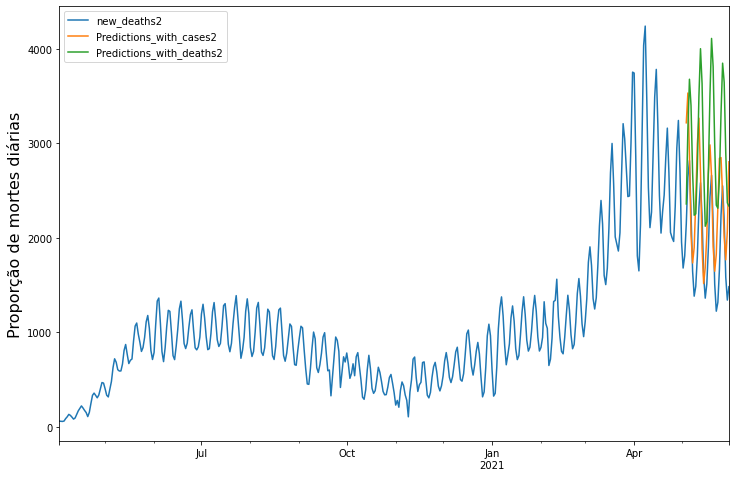

In [19]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_cases2'].plot(ax=ax)
test['Predictions_with_deaths2'].plot(ax=ax)
ax.legend()

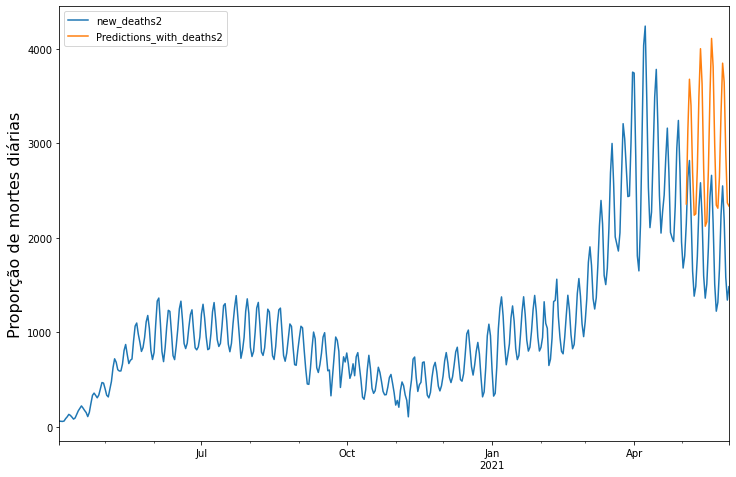

In [20]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_deaths2'].plot(ax=ax)
ax.legend()

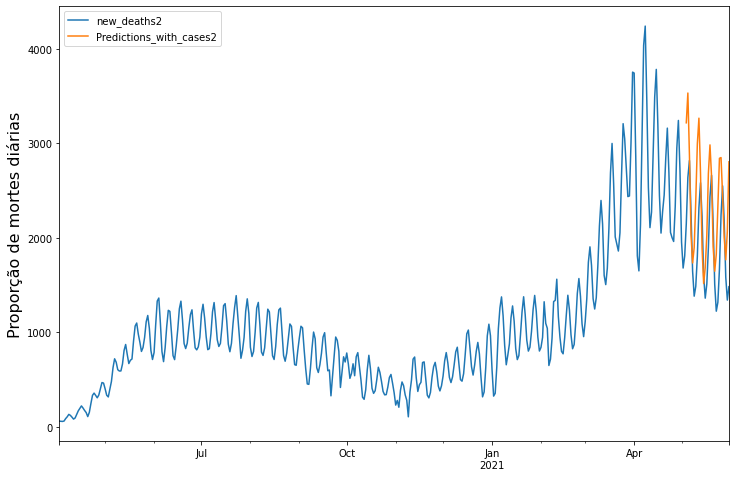

In [21]:
ax = df['new_deaths2'].plot(figsize=(12,8))
ax.set_ylabel('Proporção de mortes diárias', fontsize=16) 
test['Predictions_with_cases2'].plot(ax=ax)
ax.legend()

## Erro relativo

In [22]:
relative_errors = pd.DataFrame()
relative_errors['Predictions_with_deaths'] = round(100*np.abs(test['Predictions_with_deaths2']-test['new_deaths2'])/
                                                   test['new_deaths2'],2)
relative_errors['Predictions_with_cases'] = round(100*np.abs(test['Predictions_with_cases2']-test['new_deaths2'])/
                                                   test['new_deaths2'],2)
relative_errors

Predictions_with_deaths  Predictions_with_cases
2021-05-04                     9.74                   49.70
2021-05-05                    19.04                   33.90
2021-05-06                    30.51                    1.93
2021-05-07                    50.43                   10.06
2021-05-08                    63.33                    5.24
2021-05-09                    61.91                   37.18
2021-05-10                    51.62                   60.92
2021-05-11                    51.65                   66.09
2021-05-12                    50.85                   40.87
2021-05-13                    54.90                    4.14
2021-05-14                    63.39                   15.26
2021-05-15                    71.41                    5.13
2021-05-16                    55.83                   23.85
2021-05-17                    43.55                   34.22
2021-05-18                    43.35                   41.39
2021-05-19                    44.51                   22.60
2021-05-20                    54.42                    0.38
2021-05-21                    77.09                   11.47
2021-05-22                    97.68                    9.14
2021-05-23                    91.62                   49.25
2021-05-24                    75.45                   76.82
2021-05-25                    58.10                   69.99
2021-05-26                    48.30                   27.25
2021-05-27                    50.92                    4.12
2021-05-28                    66.84                    8.07
2021-05-29                    83.00                   11.64
2021-05-30                    76.64                   54.40
2021-05-31                    57.52                   89.05

In [23]:
# Erro relativo médio
relative_errors.mean()

Predictions_with_deaths    57.271429
Predictions_with_cases     30.859286
dtype: float64